# Tensor Compression using the CP Factorization as a Circuit

In this notebook, we use the cirkit library as to compress a tensor, such as an RGB image. To do so, we use a known low-rank tensor factorization technique -- called _the canonical polyadic (CP) factorization_ -- which we encode here as a circuit. Then, we learn the low-rank factors by minimizing the reconstruction error of the circuit approximation and by gradient descent. Therefore, you will learn how a tensor factorization can be mapped to a particular circuit structure, and how the cirkit library can be used to instantiate a CP factorization as a circuit in just a few lines of code. We start by importing some libraries and setting the seeds.

In [1]:
import random
import numpy as np
import torch

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda')

An RGB image can be represented as a tensor $\mathcal{T}\in\mathbb{R}^{3\times H\times W}$, where $H$ and $W$ denotes the height and width of the image, respectively. Below, we download an RGB image as a tensor in PyTorch, and then show it.

Shape of the image to compress: torch.Size([3, 720, 1280])


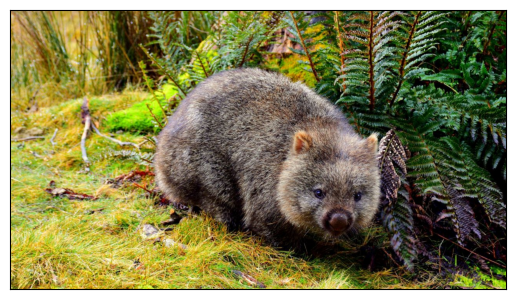

In [2]:
from torchvision import io
import matplotlib.pyplot as plt

# Download the image to compress
!wget -q "https://www.pbs.org/wnet/nature/files/2021/06/meg-jerrard-mnHs4boXT_0-unsplash-scaled-e1623262400134-1280x720.jpg" \
    -O "datasets/wombat.jpg"
# Credits to www.pbs.org/wnet/nature

original_image = io.read_image("datasets/wombat.jpg") / 255.0
print(f"Shape of the image to compress: {original_image.shape}")

# Show the image
plt.imshow(original_image.permute(1, 2, 0))
plt.xticks([], []); plt.yticks([], []); plt.show()

Given a tensor (or image) $\mathcal{T}\in\mathbb{R}^{3\times H\times W}$, we aim at finding an _approximate_ tensor $\widehat{\mathcal{T}}\in\mathbb{R}^{3\times H\times W}$ that is instead decomposed using a more memory-efficient tensor factorization. Here, we choose the CP factorization as for its simplicity. Given a CP factorization rank $R$, each entry of $\widehat{\mathcal{T}}$ is computed as
$$
\widehat{t}_{ijk} = \sum_{r=1}^R a^{(1)}_{ir} \: a^{(2)}_{jr} \: a^{(3)}_{kr},
$$
where $\mathbf{A}^{(1)}\in\mathbb{R}^{3\times r}$, $\mathbf{A}^{(2)}\in\mathbb{R}^{H\times r}$ and $\mathbf{A}^{(3)}\in\mathbb{R}^{W\times r}$ are the _factor matrices_ of the factorization. Note that for small ranks $R$, we have that the size of the factor matrices can be much smaller than the size of the tensor $\mathcal{T}$.

_But how can we encode this factorization as a circuit?_ The idea is to encode the factor matrices as _embedding_ input functions, and the products and sum with a product and sum layer, respectively. More formally, we construct a circuit $c$ over three discrete variables $\mathbf{X}=\{X_1,X_2,X_3\}$ (i.e., the number of dimensions of $\widehat{\mathcal{T}}$) such that
$$
\widehat{t}_{ijk} = c(X_1=i, X_2=j, X_3=k) = \sum_{r=1}^R f^{(1)}_{r}(X_1=i) \: f^{(2)}_{r}(X_2=j) \: f^{(3)}_{r}(X_3=k),
$$
where $f^{(1)}_r(X_1 = i) := a^{(1)}_{ir}$, $f^{(2)}_r(X_2 = j) := a^{(2)}_{jr}$, and $f^{(3)}_r(X_3 = k) := a^{(3)}_{kr}$. In other words, an evaluation of the circuit on the input $(i,j,k)$ corresponds to computing the $(i,j,k)$-th entry of the tensor $\widehat{\mathcal{T}}$.

In cirkit, we can build the symbolic circuit corresponding to the CP factorization of $\widehat{\mathcal{T}}$ in a single line as follows.

In [3]:
from cirkit.templates import tensor_factorizations, utils

# Set the factorization rank to use
factorization_rank = 48

# Construct the symbolic circuit encoding a CP tensor factorization
symbolic_circuit = tensor_factorizations.cp(
    # The shape of the tensor to which encode the CP factorization of
    # In this case, it is the shape of the image to compress
    original_image.shape,
    # The rank of the CP factorization
    rank=factorization_rank,
    # Initialize the factor matrices by sampling independently from a normal distribution
    factor_param=utils.Parameterization(
        initialization="normal",
        initialization_kwargs={"mean": 0.5, "stddev": 1.0 / np.sqrt(factorization_rank)}
    )
)

Similarly to other notebooks, here we compile the symbolic circuit using the PyTorch backend.

In [4]:
from cirkit.pipeline import PipelineContext

# Compile the symbolic circuit
ctx = PipelineContext(backend="torch", semiring="sum-product")
circuit = ctx.compile(symbolic_circuit)

Now, compressing the tensor (or image) $\mathcal{T}$ to the approximation $\widehat{\mathcal{T}}$ encoded by the circuit $c$ is equivalent to solving the following optimization problem:
$$
\widehat{\boldsymbol{\theta}} = \arg\min_{\boldsymbol{\theta}} || \mathcal{T} - \widehat{\mathcal{T}} ||_F^2 = \arg\min_{\boldsymbol{\theta}} \sum_{(i,j,k)} (t_{ijk} - c(X_1=i, X_2=j, X_3=k))^2,
$$
where $||\, \cdot\, ||_F$ denotes the Frobenius norm, and $\boldsymbol{\theta}$ is the set of parameters of $c$, which in this case are exactly the factor matrices $\mathbf{A}^{(1)}$, $\mathbf{A}^{(2)}$, $\mathbf{A}^{(3)}$.

To solve the above optimization problem by gradient descent and using PyTorch, we instantiate a data loader that samples batches of coordinates $(i,j,k)$, and minimizes the mean squared error (MSE) between $t_{ijk}$ and the output of $c$ computed on the input $(i,j,k)$. In addition, we can use any PyTorch optimizer, e.g., Adam.

In [5]:
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

# Construct a data loader that randomly samples indices of the image/tensor to approximate
batch_size = int(2 ** 14)
image_indices = np.stack(np.mgrid[0:original_image.shape[0], 0:original_image.shape[1], 0:original_image.shape[2]], axis=-1).reshape(-1, 3)
train_dataloader = DataLoader(TensorDataset(torch.from_numpy(image_indices)), shuffle=True, batch_size=batch_size, drop_last=True)
print(f"Number of image indices: {len(image_indices)}", f"Batch size: {batch_size}")

# Initialize a torch optimizer of your choice
optimizer = optim.Adam(circuit.parameters(), lr=0.1)

Number of image indices: 2764800 Batch size: 16384


In [6]:
num_epochs = 10
running_loss = 0.0
running_samples = 0

# Move the target tensor to the chosen device
original_image = original_image.to(device)

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device).unsqueeze(dim=1)

        # Compute the value of the tensor at the indices in the batch
        values = circuit(batch)  # shape (batch_dim, 1, 1)
        
        # We take the MSE as loss
        target_values = original_image[batch[:, 0, 0], batch[:, 0, 1], batch[:, 0, 2]]
        loss = torch.mean(torch.square(target_values - values[:, 0, 0]))
        loss.backward()

        # Update the parameters of the circuits, as any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
    average_mse = running_loss / running_samples
    print(f"Epoch {epoch_idx + 1}: Average MSE: {average_mse:.3f}")
    running_loss = 0.0
    running_samples = 0

Epoch 1: Average MSE: 0.374
Epoch 2: Average MSE: 0.030
Epoch 3: Average MSE: 0.023
Epoch 4: Average MSE: 0.020
Epoch 5: Average MSE: 0.018
Epoch 6: Average MSE: 0.017
Epoch 7: Average MSE: 0.016
Epoch 8: Average MSE: 0.016
Epoch 9: Average MSE: 0.015
Epoch 10: Average MSE: 0.015


Finally, we plot the original image and its reconstruction encoded by the circuit side by side.

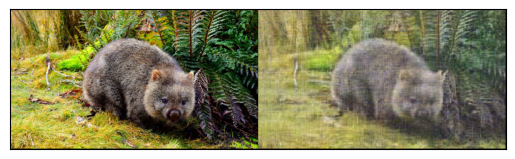

In [7]:
from torchvision.utils import make_grid

# Disable autograd from now on
circuit.eval()

# Reconstruct the image
recon_image = circuit(torch.from_numpy(image_indices).to(device).unsqueeze(dim=1))
recon_image = recon_image.squeeze(dim=2).squeeze(dim=1).view(original_image.shape)
recon_image = (recon_image - recon_image.min()) / (recon_image.max() - recon_image.min())

grid_images = make_grid([original_image, recon_image], nrow=2)
plt.imshow(grid_images.permute(1, 2, 0).cpu().numpy())
plt.xticks([], []); plt.yticks([], []); plt.show()